In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
import datetime
import pandas as pd

from palettable.colorbrewer.diverging import *
from palettable.colorbrewer.sequential import *
from calendar import monthrange

# Density profile

In [2]:
def calc_rho(vol_frac_ice, vol_frac_air):
    rho = 917 * vol_frac_ice + 1.1 * vol_frac_air
    return rho

In [3]:
path = "/pl/active/nasa_smb/scratch_bu/SNOWPACK_WAIS/input/snofiles/thwaites_1.sno"
thickness, vol_frac_ice, vol_frac_air, rg, rb, sp = np.loadtxt(path, skiprows=35, usecols=[1, 3, 5, 10, 11, 13], unpack=True)
rho = calc_rho(vol_frac_ice, vol_frac_air)
depth = np.flip(np.cumsum(np.flip(thickness)))

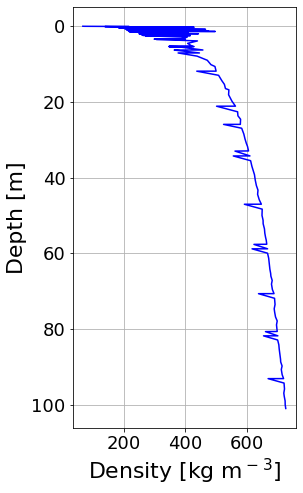

In [4]:
plt.figure(figsize=(4, 8))
plt.plot(rho, depth, 'b')
# plt.ylim([0, 10])
plt.gca().invert_yaxis()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
plt.ylabel("Depth [m]", fontsize = 22)
plt.xlabel("Density [kg m$^-$$^3$]", fontsize = 22)
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig("images/density_profile.pdf", format='pdf', dpi=100, bbox_inches='tight')

# Alpine3D grids: Erosion and deposition, wind speed

In [5]:
path = "/scratch/summit/erke2265/PRODUCTION/2015_WN/output/grids/a3d_grids_2015.nc"
ds = xr.open_dataset(path)
n_trim = 15 # 15
ds = ds.isel(easting=slice(n_trim, -n_trim))
ds = ds.isel(northing=slice(n_trim, -n_trim))
erosion_deposition = ds['WINDEROSIONDEPOSITION'].sum(dim='time')
wind_speed = ds['ws'][11::12,:,:].mean(dim='time')

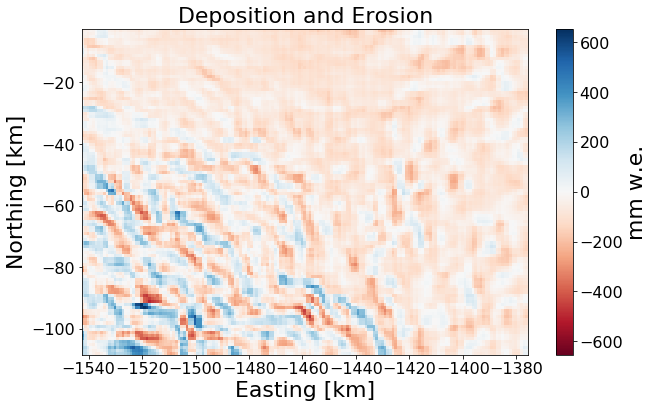

In [6]:
colormap = RdBu_11.mpl_colormap

plt.figure(figsize=(10, 6))
plt.pcolor(ds['easting']/1000, ds['northing']/1000, erosion_deposition, \
           vmin=-np.abs(erosion_deposition.values).max(), vmax=np.abs(erosion_deposition.values).max(), cmap=colormap, linewidth=0, rasterized=True)
cb = plt.colorbar()
cb.set_label("mm w.e.", fontsize=22)
cb.ax.tick_params(labelsize=16) 
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Easting [km]", fontsize=22)
plt.ylabel("Northing [km]", fontsize=22)
plt.title("Deposition and Erosion", fontsize=22)
plt.savefig("images/erosion_deposition.pdf", format='pdf', dpi=100, bbox_inches='tight')

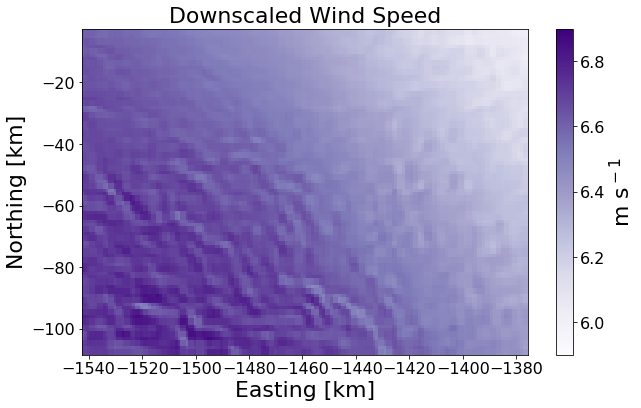

In [7]:
colormap = Purples_9.mpl_colormap

plt.figure(figsize=(10, 6))
plt.pcolor(ds['easting']/1000, ds['northing']/1000, wind_speed, cmap=colormap, vmin=5.9, vmax=6.9, linewidth=0, rasterized=True)
cb = plt.colorbar()
cb.set_label("m s$^-$$^1$", fontsize=22)
cb.ax.tick_params(labelsize=16) 
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Easting [km]", fontsize=22)
plt.ylabel("Northing [km]", fontsize=22)
plt.title("Downscaled Wind Speed", fontsize=22)
plt.savefig("images/wind_speed.pdf", format='pdf', dpi=100, bbox_inches='tight')

# ICESat-2 Surface topography

In [8]:
# Load data sets
dem_high_res = np.flipud(np.loadtxt("/scratch/summit/erke2265/SNOWPACK_WAIS/input/surface-grids/dem.asc", skiprows=6))
dem_high_res = dem_high_res[n_trim:-n_trim, n_trim:-n_trim]
dem_high_res = xr.DataArray(dem_high_res, coords=[ds['northing'], ds['easting']], dims=['northing', 'easting'])


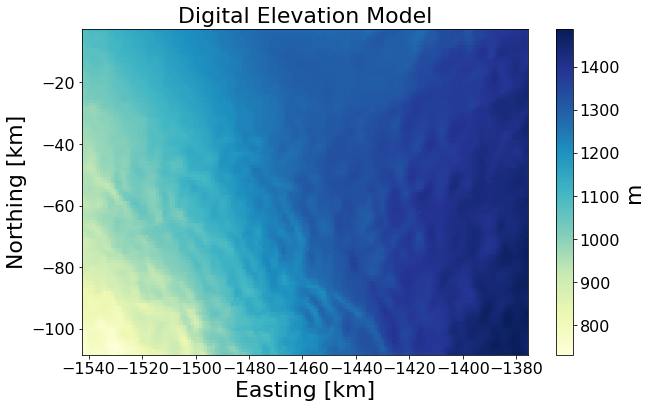

In [9]:
colormap=YlGnBu_9.mpl_colormap

plt.figure(figsize=(10, 6))
plt.pcolor(ds['easting']/1000, ds['northing']/1000, dem_high_res, cmap=colormap, linewidth=0, rasterized=True)
cb = plt.colorbar()
cb.set_label("m", fontsize=22)
cb.ax.tick_params(labelsize=16) 
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Easting [km]", fontsize=22)
plt.ylabel("Northing [km]", fontsize=22)
plt.title("Digital Elevation Model", fontsize=22)
plt.savefig("images/surface_topo.pdf", format='pdf', dpi=100, bbox_inches='tight')

# MERRA2 wind speed (Use IDW mean)
1. Run IDW on 2015 M2
2. Collect ASCII grids into NetCDF file
3. Create plot similar to WindNinja bith the same colorbar limits

In [10]:
!rm nc_files/*
directory = "/scratch/summit/erke2265/LISTON_EXPLORE/output/grids/"
months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]

# Loop over each month
for j in range(0, len(months)):
    month = months[j]
    print(month)
    datasets = []
    
    # Loop over each timestep
    for filename in os.listdir(directory):
        if (filename.startswith("2015" + month) and filename.endswith("0000.vw")) or (filename.startswith("2015" + month) and filename.endswith("1200.vw")):
            time_str = filename[0:10]
            date_time = pd.date_range(datetime.datetime.strptime(time_str, "%Y%m%d%H"), periods=1)
            path = directory + filename
            M2 = np.flipud(np.loadtxt(path, skiprows=6))
            M2 = M2[n_trim:-n_trim, n_trim:-n_trim]
            ds_M2 = xr.Dataset(
                {
                    "Wind Speed": (["northing", "easting"], M2)
                },
                coords={
                    "easting": (["easting"], 1000*ds['easting']),
                    "northing": (["northing"], 1000*ds['northing']),
                    "time": (["time"], date_time)
                }
            )
            datasets.append(ds_M2)
            
    # Write a NetCDF file for each month        
    M2 = xr.concat(datasets, dim='time')
    M2 = M2.sortby("time", ascending=True)
    M2.to_netcdf(path="nc_files/" + month + "M2_processed.nc", mode="w")    
    
# Merge month NetCDF files into one file
M2 = xr.open_mfdataset("nc_files/*M2_processed.nc")
M2 = M2.sortby("time", ascending=True)
M2.to_netcdf(path="nc_files/M2_processed.nc", mode="w")  

01
02
03
04
05
06
07
08
09
10
11
12


/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/ipykernel_launcher.py:37: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


In [11]:
M2 = xr.open_dataset("nc_files/M2_processed.nc")
M2_ws = M2['Wind Speed'].mean(dim='time')

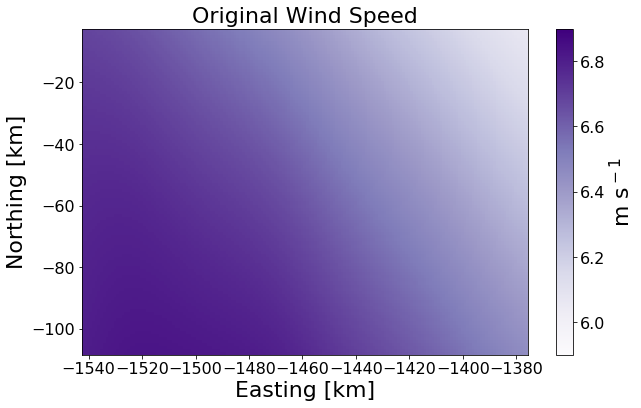

In [12]:
colormap = Purples_9.mpl_colormap

plt.figure(figsize=(10, 6))
plt.pcolor(ds['easting']/1000, ds['northing']/1000, M2_ws.values, cmap=colormap, vmin=5.9, vmax=6.9, linewidth=0, rasterized=True)
cb = plt.colorbar()
cb.set_label("m s$^-$$^1$", fontsize=22)
cb.ax.tick_params(labelsize=16) 
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Easting [km]", fontsize=22)
plt.ylabel("Northing [km]", fontsize=22)
plt.title("Original Wind Speed", fontsize=22)
plt.savefig("images/M2_wind_speed.pdf", format='pdf', dpi=100, bbox_inches='tight')